# Implémentation du schéma de Rusanov

## Importations

In [100]:
import math as math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

import numpy as np
import imageio

import time

## Paramètres du problème

In [101]:
g=1 # Constante gravitationnelle

xMin = 0
xMax = 100

N=128
h=(xMax-xMin)/(N+1) # Pas du maillage spatial

Tmax=20 # Temps Max
t=0 # Temps dans la simulation
n=0 # Nombre d'itérations

X = np.linspace(xMin,xMax,N+2) # Discrétisation de [xMin, xMax]

# Tableau avec 2 lignes et N+2 colonnes : discrétisation du vecteur (h, q) en N parties + 2 aux bords

U = 3*np.ones((2,N+2))
Uprime = np.zeros((2,N+2)) # Pour faire les calculs dans la boucle
    
def Z(x):
    #return 0.1*(x<50)*(np.arctan(x-40)+np.pi/2)+0.1*(x>=50)*(np.arctan(60-x)+np.pi/2)
    #return 0.7*(x>40)*(x<60)
    return x*0

## Nombre de sauvegardes durant la simulation

In [102]:
nSauvegarde=100
tSauvegarde=[False for i in range(nSauvegarde)]
images=[]
j=0 #Nombre de sauvegardes déjà effectuées

## Conditions initiales

In [105]:
# U[0,:] = 3*(X<=5)+1*(X>5) #Rupture de barrage barrage

U[0,:] = 1+1/(1+0.1*(X-50)**2)
U[1,:] = 0*X

## Affichage des images

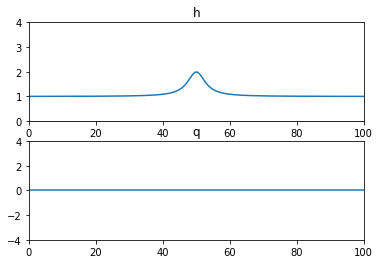

In [106]:
def affiche_U():
    
    fig, axs = plt.subplots(2,1)
    
    ###
    Z_array = Z(X)
    h_z = U[0,:]+Z_array
    axs[0].plot(X,h_z)
    ###
    
    axs[0].set_title("h")
    axs[0].set_xlim([xMin,xMax])
    axs[0].set_ylim([0,4])
    axs[0].fill_between(X, Z_array, step="pre", alpha=0.5, color="grey")
    
    axs[1].plot(X,U[1,:])
    axs[1].set_title("q")
    axs[1].set_xlim([xMin,xMax])
    axs[1].set_ylim([-4,4])
        
    plt.show()
    
affiche_U()

## Sauvegarde des images

In [107]:
def enregistre_U(n,t):

    t_int=round(t,4) # Troncature de t après la 4eme décimale
    
    fig, axs = plt.subplots(2,1)
    fig.suptitle("t="+str(t_int),fontsize=16)

    ###
    Z_array = Z(X)
    h_z = U[0,:]+Z_array
    axs[0].plot(X,h_z)
    ###
    
    axs[0].set_title("h")
    axs[0].set_xlim([xMin,xMax])
    axs[0].set_ylim([0,4])
    axs[0].fill_between(X, Z_array , step="pre", alpha=0.5,color="grey")
    
    axs[1].plot(X,U[1,:])
    axs[1].set_title("q")
    axs[1].set_xlim([xMin,xMax])
    axs[1].set_ylim([-4,4])
        
    # To remove the huge white borders
    axs[0].margins(0)
    axs[1].margins(0)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    images.append(image_from_plot)
    
    #Sauvegarde dans un fichier png
    #plt.savefig("etape"+str(n)+".png")
    
    plt.close()

## Fonctions qui interviennent dans le schéma :

Notons 
$\textbf{U}=
\begin{pmatrix}
   h \\
   q \\
\end{pmatrix}
\in\mathbb{R}^{2}$ 
le vecteur inconnu. Les différentes fonctions du schéma qu'il s'agit d'implémenter sont $\textbf{F}(\textbf{U})$, $\textbf{B}(\textbf{U})$ et $\mathcal{F}_{i+\frac{1}{2}}^n$. Rappelons les différentes définitions :

$$
\textbf{F} (\textbf{U}) =
\begin{pmatrix}
   q                                \\
   \frac{q^{2}}{h}+g\frac{h^{2}}{2} \\
\end{pmatrix}\in\mathbb{R}^{2} ~
\text{et} ~~ \textbf{B} (\textbf{U}) =
\begin{pmatrix}
   0                                \\
   -gh \frac{\partial Z}{\partial x}\\
\end{pmatrix}
\in\mathbb{R}^{2}.
$$

$\textbf{F} (\textbf{U})$ désigne la fonction flux et $\textbf{B} (\textbf{U})$ le terme source. Avec ces notations,
le système de départ se réécrit :  
  
$$\frac{\partial\textbf{U}}{\partial t}+\frac{\partial}{\partial x}(\textbf{F} (\textbf{U})) = \textbf{B} (\textbf{U}).$$  
  
Et si l'on suppose que $Z\equiv 0$, alors le schéma s'écrit simplement :  

$$\frac{\textbf{U}_i^{n+1}-\textbf{U}_i^{n}}{\Delta t^n}+\frac{\mathcal{F}_{i+\frac{1}{2}}^n - \mathcal{F}_{i-\frac{1}{2}}^n}{\Delta x_i}=0$$

Avec $$\mathcal{F}_{i+\frac{1}{2}}^n=\frac{\textbf{F}(\textbf{U}_i^{n})+\textbf{F}(\textbf{U}_{i+1}^{n})}{2}-\max_{j\in\{i,i+1\}}\max_{k\in\{1,2\}}|\lambda_k(\textbf{U}_j^n)|\frac{\textbf{U}_{i+1}^n-\textbf{U}_i^n}{2}.$$
  
En prenant une topographie $Z$ non triviale, on peut essayer de prendre le même schéma en rajoutant le terme source. Si l'on a accès à la dérivée $Z'$ de $Z$, le schéma s'écrit alors :

$$\frac{\textbf{U}_i^{n+1}-\textbf{U}_i^{n}}{\Delta t^n}+\frac{\mathcal{F}_{i+\frac{1}{2}}^n - \mathcal{F}_{i-\frac{1}{2}}^n}{\Delta x_i}= \begin{pmatrix}
0 \\
-gh_i Z'_i\\
\end{pmatrix}$$

ou bien en utilisant des différences finies centrées pour approcher les dérivées :

$$\frac{\textbf{U}_i^{n+1}-\textbf{U}_i^{n}}{\Delta t^n}+\frac{\mathcal{F}_{i+\frac{1}{2}}^n - \mathcal{F}_{i-\frac{1}{2}}^n}{\Delta x_i}= \begin{pmatrix}
0 \\
-gh_i \frac{Z_{i+1}-Z_{i-1}}{2\Delta x_i}\\
\end{pmatrix}$$

In [108]:
# Fonction F du schéma :
# Entrée : vecteur U = (h, q) (type numpy.ndarray)
# Sortie : F(U) (type numpy.ndarray)
def F(U):
    return np.array([U[1],U[1]**2/U[0]+g*U[0]**2/2])

# Fonction B du schéma :
# Entrées : * vecteur U = (h, q) (type numpy.ndarray)
#           * valeur dxZ de la dérivée spatiale de Z 
# Sortie : B(U) (type numpy.ndarray)
def B(U,dxZ):
    return np.array([0,-g*U[0]*dxZ])

# Fonction qui retourne la valeur propre max en module
# Entrées : * U solution discrétisée (type numpy.ndarray de taille 2*(N+2))
#           * indice i de la position spatiale
# Sortie : max_j max_k |λ_k(U_j^n)|
def vmax(U,i):
    res = abs(U[1,i]/U[0,i]+math.sqrt(g*U[0,i]))
    res = max(res,abs(U[1,i]/U[0,i]-math.sqrt(g*U[0,i])))
    res = max(res,abs(U[1,i+1]/U[0,i+1]+math.sqrt(g*U[0,i+1])))
    res = max(res,abs(U[1,i+1]/U[0,i+1]-math.sqrt(g*U[0,i+1])))
    return res

# Fonction flux numérique :
# Entrées : * U solution discrétisée (type numpy.ndarray de taille 2*(N+2))
#           * indice i de la position spatiale
# Sortie : F_{i+1/2}^n
def F_ronde(U,i):
    return (F(U[:,i])+F(U[:,i+1]))/2-vmax(U,i)*(U[:,i+1]-U[:,i])/2

## Boucle de résolution numérique :

Une fois le pas de temps $\Delta t^n$ déterminé, on passe du temps $t^n$ au temps $t^{n+1}$ suivant la relation explicite suivante :

$$\textbf{U}_i^{n+1}=\textbf{U}_i^{n}-\Delta t^n\frac{\mathcal{F}_{i+\frac{1}{2}}^n - \Delta t^n\mathcal{F}_{i-\frac{1}{2}}^n}{\Delta x_i}+\Delta t^n \begin{pmatrix}
0 \\
-gh_i \frac{Z_{i+1}-Z_{i-1}}{2\Delta x_i}\\
\end{pmatrix}$$

In [109]:
Z_array = Z(X)
enregistre_U(n,t)

print("Calcul en cours ...")

while(t<Tmax): # Tant que le temps max n'est pas atteint :
    
    M = vmax(U, 0)
    for i in range(1, N+1):
        M = max(M, vmax(U, i))
    # Pour assurer la stabilité, tau doit être inférieur à h/(2* max(vp))
    tau = 0.8*h/(2*M)
    
    for i in range(1, N+1):
        Uprime[0,i] = U[0,i]+tau/h*(F_ronde(U,i-1)-F_ronde(U,i))[0]
        Uprime[1,i] = U[1,i]+tau/h*(F_ronde(U,i-1)-F_ronde(U,i))[1]
        dxZ = (Z_array[i+1]-Z_array[i-1])/2/h
        Uprime[:,i] += tau*B(U[:,i], dxZ)
        
    U = Uprime
    Uprime = np.zeros((2,N+2))
    
    # Conditions aux bords
    U[:,0] = U[:,1]
    U[:,N+1] = U[:,N]

    t+=tau
    n+=1
    
    if (t > Tmax/nSauvegarde*j and (j<nSauvegarde) and (not tSauvegarde[j])):
        enregistre_U(n,t)
        #affiche_U()
        tSauvegarde[j]=True
        j+=1

print("Nombre d'itérations : " + str(n))

imageio.mimsave('movieb.gif', images)
print("Gif Sauvegardé dans le dossier sous le nom : movie.gif")

Calcul en cours ...
Nombre d'itérations : 95
Gif Sauvegardé dans le dossier sous le nom : movie.gif
